In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Replace 1 with the GPU index you want

import torch
print(torch.cuda.get_device_name(0))  # This will now refer to GPU 1 as "GPU 0" in the notebook context
print(torch.cuda.is_available())

NVIDIA A100-SXM4-80GB
True


In [2]:
import torch
print("Device count:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))


Device count: 1
Current GPU: 0
GPU name: NVIDIA A100-SXM4-80GB


In [1]:
import json

input_path = "modbus_dataset.jsonl"
output_path = "modbus_dataset_rwkv.jsonl"

with open(input_path, "r") as infile, open(output_path, "w") as outfile:
    for line in infile:
        item = json.loads(line)
        prompt = f"query: {item['query']}\n\nresponse: {item['response']}"
        outfile.write(json.dumps({"text": prompt}) + "\n")


In [2]:
import pandas as pd
import json

#Observe final Dataset
df_modbus = pd.read_json("modbus_dataset_rwkv.jsonl", lines=True)
df_modbus.head()

,text
0,query: 060f000000060005fffdff00\n\nresponse: 0...
1,query: 01b7000000060005fffdff00\n\nresponse: 0...
2,query: 05420000000d0010ec88000306831883180000\...
3,query: 005f0000000d0010fffd000306ffffffffffff\...
4,query: 05c40000000b00100026000204ffffffff\n\nr...


In [3]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="RWKV/rwkv-5-world-all-pth",
    filename="RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"
)

print(f"Model downloaded to: {model_path}")


Model downloaded to: /home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth


In [4]:
model_path = "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"


In [5]:
import json
print(json.loads('{"mode":"bone","r":32,"load":""}'))


{'mode': 'bone', 'r': 32, 'load': ''}


In [4]:
import wandb
wandb.login()


wandb: Currently logged in as: re2230 (re2230-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
cd /home/re2230


/home/re2230


/home/re2230/rwkv-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [52]:
import json

# Paths to input files
modbus_path = "/home/re2230/modbus_dataset.jsonl"
modbusa_test_path = "/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test.jsonl"
output_path = "/home/re2230/combined_modbus_dataset.jsonl"

# Read the first dataset
with open(modbus_path, "r") as f:
    modbus_data = [json.loads(line) for line in f]

# Read the second dataset (only lines 21 to 50)
with open(modbusa_test_path, "r") as f:
    modbusa_lines = f.readlines()[20:159]  # lines 21 to 160 (0-indexed)
    modbusa_data = [json.loads(line) for line in modbusa_lines]

# Combine datasets
combined_data = modbus_data + modbusa_data

# Write to new file
with open(output_path, "w") as f:
    for entry in combined_data:
        f.write(json.dumps(entry) + "\n")

print(f"✅ Combined dataset written to {output_path}")

✅ Combined dataset written to /home/re2230/combined_modbus_dataset.jsonl


In [53]:
import json

input_path = "/home/re2230/combined_modbus_dataset.jsonl"
output_path = "/home/re2230/combined_modbus_dataset_rwkv.jsonl"

with open(input_path, "r") as infile, open(output_path, "w") as outfile:
    for line in infile:
        item = json.loads(line)
        prompt = f"query: {item['query']}\n\nresponse: {item['response']}"
        outfile.write(json.dumps({"text": prompt}) + "\n")


In [ ]:
#TRAINING WITH SFT FORMAT

import subprocess
import shlex
import os

# Activar seguimiento en Weights & Biases
os.environ["WANDB_PROJECT"] = "rwkv-finetune"

from datasets import load_dataset

dataset = load_dataset("json", data_files="modbus_dataset_rwkv.jsonl")

model_path = "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"

command = f"""
python RWKV-PEFT/train.py \
--load_model {model_path} \
--data_file json \
--data_files /home/re2230/modbus_dataset.jsonl \
--data_type sft \
--sft_field query response \
--ctx_len 512 \
--epoch_steps 50 \
--epoch_count 50 \
--micro_bsz 1 \
--n_layer 24 \
--n_embd 1024 \
--vocab_size 65536 \
--lr_init 6e-5 \
--warmup_steps 10 \
--strategy deepspeed \
--accelerator cuda \
--precision bf16 \
--peft disha \
--disha_config '{{"mode":"bone","r":32,"load":""}}' \
--proj_dir out/rwkv-modbus-ft
"""


result = subprocess.run(shlex.split(command), capture_output=True, text=True)

print("📤 STDOUT:\n", result.stdout)
print("⚠️ STDERR:\n", result.stderr)

if result.returncode != 0:
    print(f"❌ Training failed with exit code {result.returncode}")
else:
    print("✅ Training started successfully")   


In [ ]:
#TRAINING WITH JSONL FORMAT

import subprocess
import shlex
import os

# Activar seguimiento en Weights & Biases
os.environ["WANDB_PROJECT"] = "rwkv-finetune"

from datasets import load_dataset

dataset = load_dataset("json", data_files="modbus_dataset_rwkv.jsonl")

model_path = "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"

command = f"""
python RWKV-PEFT/train.py \
--load_model {model_path} \
--data_file /home/re2230/combined_modbus_dataset_rwkv.jsonl \
--data_type jsonl \
--sft_field text \
--ctx_len 512 \
--epoch_steps 50 \
--epoch_count 50 \
--micro_bsz 1 \
--n_layer 24 \
--n_embd 1024 \
--vocab_size 65536 \
--lr_init 6e-5 \
--warmup_steps 10 \
--strategy deepspeed \
--accelerator cuda \
--precision bf16 \
--peft disha \
--disha_config '{{"mode":"bone","r":32,"load":""}}' \
--proj_dir out/rwkv-modbus-ft
"""


result = subprocess.run(shlex.split(command), capture_output=True, text=True)

print("📤 STDOUT:\n", result.stdout)
print("⚠️ STDERR:\n", result.stderr)

if result.returncode != 0:
    print(f"❌ Training failed with exit code {result.returncode}")
else:
    print("✅ Training started successfully")  


#Not combined dataset : Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: 1.228
#Monitored metric val_loss did not improve in the last 3 records. Best score: 1.228. Signaling Trainer to stop. 


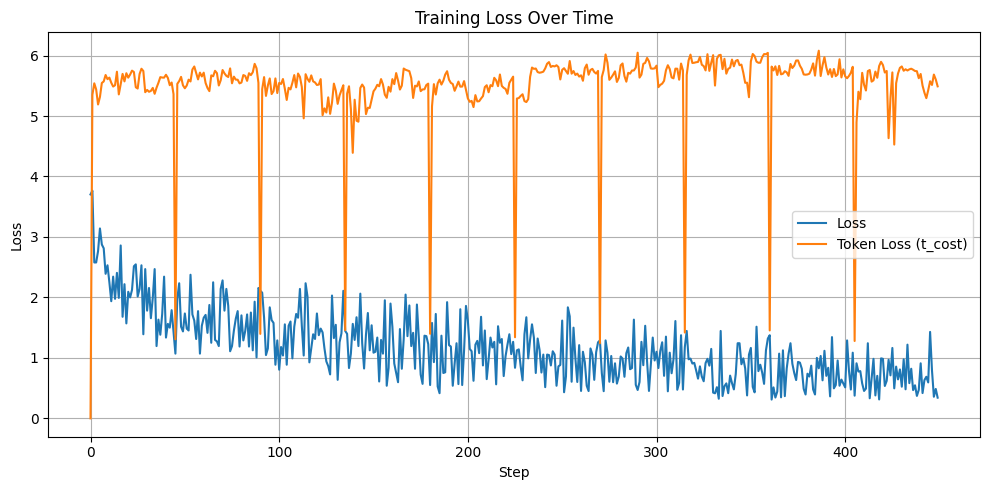

In [44]:
import json
import matplotlib.pyplot as plt

# "loss" – general loss (probably for display)
# "t_cost" – training loss per step (token-level)
# "kt_s" – possibly token-level speed or time per step (not performance-related)

# Load data
with open("/home/re2230/out/rwkv-modbus-ft/loss_data.json") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Extract loss values
steps = list(range(len(data)))
loss = [entry["loss"] for entry in data]
t_cost = [entry["t_cost"] for entry in data]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(steps, loss, label="Loss")
plt.plot(steps, t_cost, label="Token Loss (t_cost)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import sys
import os


In [7]:
# Entorno necesarias para RWKV-PEFT
os.environ["RWKV_HEAD_SIZE_A"] = "64"
os.environ["RWKV_MY_TESTING"] = "x052"
os.environ["RWKV_MY_TESTING"] = "x052"
os.environ["RWKV_TRAIN_TYPE"] = "sft"
os.environ["WKV"] = "cuda"
os.environ["FUSED_KERNEL"] = "1"



In [8]:
sys.path.append("/home/re2230/RWKV-PEFT")

In [9]:
import torch

ckpt = torch.load(
    "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
    map_location="cpu"
)

print("Number of layers:", len([k for k in ckpt if "blocks." in k and ".att." in k and ".ln_x.weight" in k]))
print("Embedding size (n_embd):", ckpt["blocks.0.att.ln_x.weight"].shape[0])


Number of layers: 24
Embedding size (n_embd): 1024


In [14]:
import torch

ckpt_path = "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

# Look for an attention-related key to infer context length
for k in ckpt:
    if "time_decay" in k:
        print(k, ckpt[k].shape)
        break


blocks.0.att.time_decay torch.Size([16, 64])


In [10]:
import json

input_path = "/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test.jsonl"
output_path = "/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test_rwkv.jsonl"

with open(input_path, "r") as infile, open(output_path, "w") as outfile:
    for line in infile:
        item = json.loads(line)
        prompt = f"query: {item['query']}\n\nresponse: {item['response']}"
        outfile.write(json.dumps({"text": prompt}) + "\n")


In [ ]:
#INFERENCE JSONL FORMAT 
import torch
from types import SimpleNamespace  
from datasets import load_dataset
from transformers import AutoTokenizer
from rwkvt.peft.peft_loading import load_peft_model
import random
import jsonlines
from tqdm import tqdm

args = SimpleNamespace(
    # Required paths
    load_model="/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
    # adapter_path="/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth",
    adapter_path = "/home/re2230/out/rwkv-modbus-ft/rwkv-49.pth",
    # RWKV core
    device="cuda" if torch.cuda.is_available() else "cpu",
    dtype="bf16",
    grad_cp=0,  # No gradient checkpointing during inference
    # PEFT-specific
    peft="disha",
    disha_config={"mode": "bone", "r": 32, "load": ""},
    train_parts="",
    my_pile_stage=0,
    # Required flags (even if unused)
    quant="none",
    lora_config=None,
    pissa_config=None,
    #  Required model hyperparameters
    vocab_size=65536,
    n_layer=24,
    n_embd=1024,
    ctx_len=4096,
    dim_att=1024,
    # n_layer=24,
    # n_embd=1024,
    # dim_att=768,
    dim_ffn=3584,
    head_size_a=64,
    head_size_divisor=8 
)


# model = load_peft_model(args)
args, model = load_peft_model(args)
print(type(model))

model = model.to(dtype=torch.bfloat16, device="cuda").eval()

tokenizer = AutoTokenizer.from_pretrained(
    "RWKV/rwkv-5-world-3b",
    trust_remote_code=True
)

# Step 2: Define Prompt Format

# PROMPT = "{instruction}"
PROMPT = "query: {instruction}\n\nresponse:"


def generate_response(instruction, model, tokenizer, args, max_new_tokens=20):
    prompt = PROMPT.format(instruction=instruction)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(args.device)
    print(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(input_ids)
            logits = out[0] if isinstance(out, tuple) else out
            next_token = torch.argmax(logits[:, -1], dim=-1).unsqueeze(0)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

# Step 3: Load Dataset

dataset = load_dataset("json", data_files="/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test_rwkv.jsonl")["train"]

# Limit to first N examples (e.g., 100)
max_examples = 20
dataset = dataset.select(range(min(len(dataset), max_examples)))


results = []

import re


for item in tqdm(dataset):
    full_text = item["text"].strip()
    
    # Use regex to extract query and response
    match = re.match(r"query:\s*(.+?)\s*\n\nresponse:\s*(.+)", full_text)
    if not match:
        print("❌ Format error:", full_text)
        continue

    query = match.group(1).strip()
    expected_response = match.group(2).strip()

    # Generate model response
    output = generate_response(query, model, tokenizer, args)

    # Save result
    results.append({
        "query": query,
        "expected_response": expected_response,
        "generated_response": output.strip()
    })


# Guarda las predicciones
with jsonlines.open("rwkv_modbus_outputs.jsonl", mode='w') as writer:
    for r in results:
        writer.write(r)

print("✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'")


########## Loading /home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth... ##########


RWKV(
  (model): RWKV5(
    (emb): Embedding(65536, 1024)
    (blocks): ModuleList(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (att): RWKV_TimeMix_RWKV5(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): BoneLinear()
          (key): BoneLinear()
          (value): BoneLinear()
          (output): BoneLinear()
          (gate): BoneLinear()
          (ln_x): GroupNorm(16, 1024, eps=1e-05, affine=True)
        )
        (ffn): RWKV_ChannelMix(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (key): BoneLinear()
          (receptance): BoneLinear()
          (value): BoneLinear()
        )
      )
      (1-23): 23 x Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     

  0%|          | 0/20 [00:00<?, ?it/s]

['<s>', 'query', ':', ' 02', '1', 'd', '00', '00', '00', '06', '00', '03', 'fff', 'd', '00', '02', '\n\n', 'response', ':']


  5%|▌         | 1/20 [00:00<00:15,  1.25it/s]

['<s>', 'query', ':', ' 01', '2', 'c', '00', '00', '00', '06', '00', '05', 'fff', 'df', 'f', '00', '\n\n', 'response', ':']


 10%|█         | 2/20 [00:01<00:14,  1.28it/s]

['<s>', 'query', ':', ' 03', 'eb', '00', '00', '00', '06', '00', '05', '00', '09', '00', '00', '\n\n', 'response', ':']


 15%|█▌        | 3/20 [00:02<00:12,  1.36it/s]

['<s>', 'query', ':', ' 04', '5', 'd', '00', '00', '00', '06', '00', '01', 'fff', 'e', '00', '01', '\n\n', 'response', ':']


 20%|██        | 4/20 [00:02<00:11,  1.36it/s]

['<s>', 'query', ':', ' 06', '10', '00', '00', '00', '0', 'd', '00', '10', '00', '28', '00', '03', '06', '00', '00', 'ffff', '00', '00', '\n\n', 'response', ':']


 25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

['<s>', 'query', ':', ' 05', '8', 'd', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02', '\n\n', 'response', ':']


 30%|███       | 6/20 [00:04<00:10,  1.36it/s]

['<s>', 'query', ':', ' 03', '20', '00', '00', '00', '06', '00', '03', '00', '28', '00', '01', '\n\n', 'response', ':']


 35%|███▌      | 7/20 [00:05<00:09,  1.37it/s]

['<s>', 'query', ':', ' 02', '3', 'a', '00', '00', '00', '06', '00', '03', 'fff', 'e', '00', '01', '\n\n', 'response', ':']


 40%|████      | 8/20 [00:05<00:08,  1.37it/s]

['<s>', 'query', ':', ' 03', '82', '00', '00', '00', '0', 'd', '00', '10', '00', '25', '00', '03', '06', '00', '00', 'a', '99', '4', 'a', '99', '4', '\n\n', 'response', ':']


 45%|████▌     | 9/20 [00:06<00:07,  1.38it/s]

['<s>', 'query', ':', ' 02', '53', '00', '00', '00', '06', '00', '03', '00', '00', '00', '02', '\n\n', 'response', ':']


 50%|█████     | 10/20 [00:07<00:07,  1.38it/s]

['<s>', 'query', ':', ' 04', 'd', '20', '00', '00', '00', '60', '00', '50', '02', '8', 'ff', '00', '\n\n', 'response', ':']


 55%|█████▌    | 11/20 [00:08<00:06,  1.37it/s]

['<s>', 'query', ':', ' 05', '46', '00', '00', '00', '06', '00', '03', '00', '00', '00', '01', '\n\n', 'response', ':']


 60%|██████    | 12/20 [00:08<00:05,  1.38it/s]

['<s>', 'query', ':', ' 02', 'ca', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02', '\n\n', 'response', ':']


 65%|██████▌   | 13/20 [00:09<00:05,  1.40it/s]

['<s>', 'query', ':', ' 03', '4', 'f', '00', '00', '00', '06', '00', '01', 'eb', '18', '00', '02', '\n\n', 'response', ':']


 70%|███████   | 14/20 [00:10<00:04,  1.39it/s]

['<s>', 'query', ':', ' 00', '56', '00', '00', '00', '06', '00', '03', '00', '25', '00', '02', '\n\n', 'response', ':']


 75%|███████▌  | 15/20 [00:10<00:03,  1.40it/s]

['<s>', 'query', ':', ' 05', 'fe', '00', '00', '00', '06', '00', '03', 'cab', '30', '00', '2', '\n\n', 'response', ':']


 80%|████████  | 16/20 [00:11<00:02,  1.39it/s]

['<s>', 'query', ':', ' 01', 'a', '20', '00', '00', '00', '60', '00', '30', '01', '20', '00', '2', '\n\n', 'response', ':']


 85%|████████▌ | 17/20 [00:12<00:02,  1.40it/s]

['<s>', 'query', ':', ' 05', '66', '00', '00', '00', '06', '00', '01', 'fff', 'e', '00', '01', '\n\n', 'response', ':']


 90%|█████████ | 18/20 [00:13<00:01,  1.41it/s]

['<s>', 'query', ':', ' 05', '0', 'c', '00', '00', '00', '0', 'd', '00', '10', 'fff', 'd', '00', '03', '06', 'ffffffff', '83', '18', '\n\n', 'response', ':']


 95%|█████████▌| 19/20 [00:13<00:00,  1.42it/s]

['<s>', 'query', ':', ' 04', '47', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02', '\n\n', 'response', ':']


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'


In [46]:
#EVALUATING INFERENCE

import jsonlines

def hex_accuracy(pred, target):
    pred_bytes = [pred[i:i+2] for i in range(0, len(pred), 2)]
    target_bytes = [target[i:i+2] for i in range(0, len(target), 2)]
    if not target_bytes:
        return 0.0
    correct = sum(p == t for p, t in zip(pred_bytes, target_bytes))
    return correct / len(target_bytes)

accuracies = []

with jsonlines.open("rwkv_modbus_outputs.jsonl") as reader:
    for entry in reader:
        acc = hex_accuracy(entry["generated_response"], entry["expected_response"])
        accuracies.append(acc)

print(f"✅ Test Byte Accuracy: {sum(accuracies)/len(accuracies):.2%}")


✅ Test Byte Accuracy: 12.24%


In [ ]:
# data_type sft #Select data type
# sft_field query response #Perform retrieval based on the question-and-answer format in the JSON.
# sft_split "train" #Set the number of data to load: "train" loads all the data, while "train[:1000]" loads only the first 1000 samples.
# --data_type sft --sft_field query response --sft_split "train"

In [48]:
#INFERENCE JSONL FORMAT AND TIME OF INFERENCE 

import torch
from types import SimpleNamespace  # 🔄 Replacement for InferenceArgs
from datasets import load_dataset
from transformers import AutoTokenizer
from rwkvt.peft.peft_loading import load_peft_model
import random
import jsonlines
from tqdm import tqdm
import time

results = []
total_time = 0
num_queries = 0

args = SimpleNamespace(
    # Required paths
    load_model="/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
    # adapter_path="/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth",
    adapter_path = "/home/re2230/out/rwkv-modbus-ft/rwkv-49.pth",
    
    # RWKV core
    device="cuda" if torch.cuda.is_available() else "cpu",
    dtype="bf16",
    grad_cp=0,  # No gradient checkpointing during inference


    # PEFT-specific
    peft="disha",
    disha_config={"mode": "bone", "r": 32, "load": ""},
    train_parts="",
    my_pile_stage=0,

    # Required flags (even if unused)
    quant="none",
    lora_config=None,
    pissa_config=None,

    # ✅ Required model hyperparameters
    vocab_size=65536,
    n_layer=24,
    n_embd=1024,
    ctx_len=4096,
    dim_att=1024,
    # n_layer=24,
    # n_embd=1024,
    # dim_att=768,
    dim_ffn=3584,
    head_size_a=64,
    head_size_divisor=8 
)


# model = load_peft_model(args)
args, model = load_peft_model(args)
print(type(model))

model = model.to(dtype=torch.bfloat16, device="cuda").eval()

tokenizer = AutoTokenizer.from_pretrained(
    "RWKV/rwkv-5-world-3b",
    trust_remote_code=True
)

# Step 2: Define Prompt Format

# PROMPT = "{instruction}"
prompt = "query: {instruction}\n\nresponse:"


def generate_response(instruction, model, tokenizer, args, max_new_tokens=10):
    prompt = PROMPT.format(instruction=instruction)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(args.device)
    print(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(input_ids)
            logits = out[0] if isinstance(out, tuple) else out
            next_token = torch.argmax(logits[:, -1], dim=-1).unsqueeze(0)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)



# Step 3: Load Dataset

dataset = load_dataset("json", data_files="/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test_rwkv.jsonl")["train"]

# Limit to first N examples (e.g., 100)
max_examples = 20
dataset = dataset.select(range(min(len(dataset), max_examples)))


results = []

import re


for item in tqdm(dataset):
    full_text = item["text"].strip()
    
    # Use regex to extract query and response
    match = re.match(r"query:\s*(.+?)\s*\n\nresponse:\s*(.+)", full_text)
    if not match:
        print("❌ Format error:", full_text)
        continue

    query = match.group(1).strip()
    expected_response = match.group(2).strip()

    start_time = time.time()
    output = generate_response(query, model, tokenizer, args)
    elapsed = time.time() - start_time
    

    # Save result
    results.append({
        "query": query,
        "expected_response": expected_response,
        "generated_response": output.strip()
    })

    total_time += elapsed
    num_queries += 1

avg_time = total_time / num_queries
print(f"Inference complete. Avg time per query: {avg_time:.4f} seconds")


# Guarda las predicciones
with jsonlines.open("rwkv_modbus_outputs.jsonl", mode='w') as writer:
    for r in results:
        writer.write(r)

print("✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'")


########## Loading /home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth... ##########


RWKV(
  (model): RWKV5(
    (emb): Embedding(65536, 1024)
    (blocks): ModuleList(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (att): RWKV_TimeMix_RWKV5(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): BoneLinear()
          (key): BoneLinear()
          (value): BoneLinear()
          (output): BoneLinear()
          (gate): BoneLinear()
          (ln_x): GroupNorm(16, 1024, eps=1e-05, affine=True)
        )
        (ffn): RWKV_ChannelMix(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (key): BoneLinear()
          (receptance): BoneLinear()
          (value): BoneLinear()
        )
      )
      (1-23): 23 x Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     

  0%|          | 0/20 [00:00<?, ?it/s]

['<s>', '02', '1', 'd', '00', '00', '00', '06', '00', '03', 'fff', 'd', '00', '02', ',', ' response', ':']


  5%|▌         | 1/20 [00:00<00:06,  2.79it/s]

['<s>', '01', '2', 'c', '00', '00', '00', '06', '00', '05', 'fff', 'df', 'f', '00', ',', ' response', ':']


 10%|█         | 2/20 [00:00<00:06,  2.82it/s]

['<s>', '03', 'eb', '00', '00', '00', '06', '00', '05', '00', '09', '00', '00', ',', ' response', ':']


 15%|█▌        | 3/20 [00:01<00:06,  2.81it/s]

['<s>', '04', '5', 'd', '00', '00', '00', '06', '00', '01', 'fff', 'e', '00', '01', ',', ' response', ':']


 20%|██        | 4/20 [00:01<00:05,  2.82it/s]

['<s>', '06', '10', '00', '00', '00', '0', 'd', '00', '10', '00', '28', '00', '03', '06', '00', '00', 'ffff', '00', '00', ',', ' response', ':']


 25%|██▌       | 5/20 [00:01<00:05,  2.86it/s]

['<s>', '05', '8', 'd', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02', ',', ' response', ':']


 30%|███       | 6/20 [00:02<00:04,  2.83it/s]

['<s>', '03', '20', '00', '00', '00', '06', '00', '03', '00', '28', '00', '01', ',', ' response', ':']


 35%|███▌      | 7/20 [00:02<00:04,  2.86it/s]

['<s>', '02', '3', 'a', '00', '00', '00', '06', '00', '03', 'fff', 'e', '00', '01', ',', ' response', ':']


 40%|████      | 8/20 [00:02<00:04,  2.90it/s]

['<s>', '03', '82', '00', '00', '00', '0', 'd', '00', '10', '00', '25', '00', '03', '06', '00', '00', 'a', '99', '4', 'a', '99', '4', ',', ' response', ':']


 45%|████▌     | 9/20 [00:03<00:03,  2.92it/s]

['<s>', '02', '53', '00', '00', '00', '06', '00', '03', '00', '00', '00', '02', ',', ' response', ':']


 50%|█████     | 10/20 [00:03<00:03,  2.92it/s]

['<s>', '04', 'd', '20', '00', '00', '00', '60', '00', '50', '02', '8', 'ff', '00', ',', ' response', ':']


 55%|█████▌    | 11/20 [00:03<00:03,  2.87it/s]

['<s>', '05', '46', '00', '00', '00', '06', '00', '03', '00', '00', '00', '01', ',', ' response', ':']


 60%|██████    | 12/20 [00:04<00:02,  2.90it/s]

['<s>', '02', 'ca', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02', ',', ' response', ':']


 65%|██████▌   | 13/20 [00:04<00:02,  2.92it/s]

['<s>', '03', '4', 'f', '00', '00', '00', '06', '00', '01', 'eb', '18', '00', '02', ',', ' response', ':']


 70%|███████   | 14/20 [00:04<00:02,  2.86it/s]

['<s>', '00', '56', '00', '00', '00', '06', '00', '03', '00', '25', '00', '02', ',', ' response', ':']


 75%|███████▌  | 15/20 [00:05<00:01,  2.87it/s]

['<s>', '05', 'fe', '00', '00', '00', '06', '00', '03', 'cab', '30', '00', '2', ',', ' response', ':']


 80%|████████  | 16/20 [00:05<00:01,  2.88it/s]

['<s>', '01', 'a', '20', '00', '00', '00', '60', '00', '30', '01', '20', '00', '2', ',', ' response', ':']


 85%|████████▌ | 17/20 [00:05<00:01,  2.90it/s]

['<s>', '05', '66', '00', '00', '00', '06', '00', '01', 'fff', 'e', '00', '01', ',', ' response', ':']


 90%|█████████ | 18/20 [00:06<00:00,  2.90it/s]

['<s>', '05', '0', 'c', '00', '00', '00', '0', 'd', '00', '10', 'fff', 'd', '00', '03', '06', 'ffffffff', '83', '18', ',', ' response', ':']


 95%|█████████▌| 19/20 [00:06<00:00,  2.90it/s]

['<s>', '04', '47', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02', ',', ' response', ':']


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]

Inference complete. Avg time per query: 0.3462 seconds
✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'


In [ ]:
#INFERENCE WITH SFT TRAINING
import torch
from types import SimpleNamespace  # 🔄 Replacement for InferenceArgs
from datasets import load_dataset
from transformers import AutoTokenizer
from rwkvt.peft.peft_loading import load_peft_model
import random
import jsonlines
from tqdm import tqdm

args = SimpleNamespace(
    # Required paths
    load_model="/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
    adapter_path="/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth",

    # RWKV core
    device="cuda" if torch.cuda.is_available() else "cpu",
    dtype="bf16",
    grad_cp=0,  # No gradient checkpointing during inference


    # PEFT-specific
    peft="disha",
    disha_config={"mode": "bone", "r": 32, "load": ""},
    train_parts="",
    my_pile_stage=0,

    # Required flags (even if unused)
    quant="none",
    lora_config=None,
    pissa_config=None,

    # ✅ Required model hyperparameters
    vocab_size=65536,
    n_layer=24,
    n_embd=1024,
    ctx_len=4096,
    dim_att=1024,
    # n_layer=24,
    # n_embd=1024,
    # dim_att=768,
    dim_ffn=3584,
    head_size_a=64,
    head_size_divisor=8 
)


# model = load_peft_model(args)
args, model = load_peft_model(args)
print(type(model))

model = model.to(dtype=torch.bfloat16, device="cuda").eval()

tokenizer = AutoTokenizer.from_pretrained(
    "RWKV/rwkv-5-world-3b",
    trust_remote_code=True
)

# Step 2: Define Prompt Format

PROMPT = "{instruction}"

def generate_response(instruction, model, tokenizer, args, max_new_tokens=100):
    prompt = PROMPT.format(instruction=instruction)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(args.device)
    print(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(input_ids)
            logits = out[0] if isinstance(out, tuple) else out
            next_token = torch.argmax(logits[:, -1], dim=-1).unsqueeze(0)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)



# Step 3: Load Dataset

dataset = load_dataset("json", data_files="/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test.jsonl")["train"]

# Limit to first N examples (e.g., 100)
max_examples = 20
dataset = dataset.select(range(min(len(dataset), max_examples)))


results = []

# Procesamiento por ejemplo
for item in tqdm(dataset):
    query = item["query"].strip()
    if not query:
        continue

    output = generate_response(query, model, tokenizer, args)

    results.append({
        "query": query,
        "expected_response": item["response"],
        "generated_response": output.strip()
    })


# Guarda las predicciones
with jsonlines.open("rwkv_modbus_outputs.jsonl", mode='w') as writer:
    for r in results:
        writer.write(r)

print("✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'")
